# Coupled Simple Land Simulations

##### Marysa M Laguë
##### 2017.05.09

## Sensitivity Analysis (take 1)
The idea here is that, rather than simply looking at the atmospheric sensitivity to a prescribed $\Delta$ land property, I'd like to flip the relationship to explore how large a $\Delta$ land property is required to get a given atmospheric response (e.g. a 1K change in 2m air temperature).

For now, I'll do this locally, and assume a linear relationship between the surface perturbation and the atmospheric response. 

## Setup 
(This section just has code needed to manipulate the netcdf files, make plots, load data, etc)


In [1]:
# For interactive in-line plots:
#%matplotlib nbagg  

# For inline plots:
%matplotlib inline     

# netcdf/numpy/xarray
import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
from numpy import ma
from scipy import stats
import scipy.io as sio
#import cpickle as pickle
import pickle as pickle
from sklearn import linear_model

import time

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import brewer2mpl as cbrew

# OS interaction
import os
import sys

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [2]:
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

### Directories

In [3]:
##### Directory Lists
## Unix
#if 'linux' in sys.platform:
#    dir_pre = '/home/lapok/gdrive/'
## Mac
#elif 'darwin' in sys.platform:
#    dir_pre = '/Users/karllapo/gdrive/'

# My local root directory
dir_root = '/home/disk/eos3/mlague/'

# Where, wrt root, to find the data and save the plots
dir_data = dir_root + '/cesmruns/SimpleLand/global_pert/'
dir_fig = dir_root + '/simple_land/scripts/python/analysis/global_pert/figures/sensitivity/'

# Names of the albedo simulations
#sims = ['global_a2_cv2_hc1_rs100',
#       'global_a1_cv2_hc1_rs100','global_a3_cv2_hc1_rs100']
sims = ['global_a2_cv2_hc1_rs100',
       'global_a1_cv2_hc1_rs100','global_a3_cv2_hc1_rs100',
       'global_a2_cv1.5_hc1_rs100','global_a2_cv3_hc1_rs100',
       'global_a2_cv2_hc0.5_rs100','global_a2_cv2_hc10_rs100',
       'global_a2_cv2_hc1_rs30','global_a2_cv2_hc1_rs200']

#load the file paths and # Open the coupled data sets in xarray
cam_files = {}
clm_files = {}
ds_cam = {}
ds_clm = {}

for run in sims:
    #print ( ext_dir + run + '/means/' + run + '.cam.h0.05-end_year_avg.nc' )
    cam_files[run] = dir_data + run + '/means/' + run + '.cam.h0.05-end_year_avg.nc'
    clm_files[run] = dir_data + run + '/means/' + run + '.clm2.h0.05-end_year_avg.nc'
    
    ds_cam[run] = xr.open_dataset(cam_files[run])
    ds_clm[run] = xr.open_dataset(clm_files[run])


# open a cam area file produced in matlab using an EarthEllipsoid from a cam5 f19 lat/lon data set
area_f19_mat = sio.loadmat('/home/disk/eos3/mlague/simple_land/scripts/python/analysis/f19_area.mat')
area_f19 = area_f19_mat['AreaGrid']


#

/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:389: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:408: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


### Functions

##### Plotting

## Maps:

### Pickle a map projection, because it is very slow to make one from scratch

In [4]:
def make_basemap():
    
    dsa = ds_cam['global_a2_cv2_hc1_rs100']
    lat = dsa['lat'].values
    lon = dsa['lon'].values
    dsl = ds_clm['global_a2_cv2_hc1_rs100']
    landmask = dsl['landmask'].values
    
    LN,LT = np.meshgrid(lon,lat)
    
    
    # Make a basic basemap robin projection; this centres the Pacific, which isn't ideal, but 
    # I'll need to roll the data around 180 degrees to make it play nice I think...
    t1 = time.clock()
    
    fig = plt.figure()
    
    mp = Basemap(projection='robin',ellps='WGS84',lon_0=180.,lat_0=0.,resolution='c');
    mp.drawcoastlines()
    #mp.drawcountries()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    
    #with open(basemap_pkl, 'w') as f:
    #        pickle.dump(mp, f, pickle.HIGHEST_PROTOCOL)
            
    # Pickle the basemap for use later
    #pickle.dump(mp,open(dir_fig + 'map.pickle','wb'),-1)  # pickle it 

    #plt.clf

    print(time.clock()-t1,' secs to create original Basemap instance')
    
    return mp
    # dispose of mp so we don't accidentally use it later. 
    #del mp
    # load the pickle in later:
    # mp = pickle.load( open( dir_fig + 'map.pickle', 'rb' ) )
    
def get_basemap():
    with open(basemap_pkl, 'r') as f:
            return pickle.load(f)
    return mp



In [5]:

def mml_fig(LN,LT,mapdata,ds,myvar,proj=None,title=None,clim=None,colmap=None,units=None):
    #x_data, y_data, x_label, y_label, title=None, xlim=None, ylim=None
    ''' Desctiption of function goes here. Also, single and double quotes are the same...'''

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0, ellps='WGS84',resolution='c') # can't make it start anywhere other than 180???
    mp.drawcoastlines()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    #(x, y) = m(LONXY, LATXY)
    cs = mp.pcolormesh(LN,LT,mapdata,cmap=plt.cm.inferno,latlon=True)
    
    if cm:
        cs.cmap = colmap
    else:
        cs.cmap = plt.cm.inferno    
    
    cbar = mp.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('units: '+ds[myvar].units)
    
    if title:
        plt.title(title,fontsize=12)
    else:
        plt.title(ds[myvar].long_name,fontsize=12)
    
    if clim:
        cbar.set_clim(clim[0],clim[1])
        cs.set_clim(clim[0],clim[1])
    
    
    
    
    #plt.suptitle('units?')
    #plt.show()
    
    
    #plt.show()
    return fig, mp, ax, cbar, cs

def mml_map(LN,LT,mapdata,ds,myvar,proj,title=None,clim=None,colmap=None,cb_ttl=None):
    # need to have already opened a figure/axis
    #plt.sca(ax)
    
    # There is a way to make a single basemap, save it, and just call that vover and over, ie a blank little map, 
    # that we then build maps on top of (pcolours)
    mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0,resolution='c') # can't make it start anywhere other than 180???
    mp.drawcoastlines()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    #(x, y) = m(LONXY, LATXY)
    cs = mp.pcolormesh(LN,LT,mapdata,cmap=plt.cm.inferno,latlon=True)
    
    if cm:
        cs.cmap = colmap
    else:
        cs.cmap = plt.cm.inferno    
    
    cbar = mp.colorbar(cs,location='bottom',pad="5%")
    
    cmap.set_bad('white',1.)
    
    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=12)
    else:
        cbar.set_label('units: '+ds[myvar].units,fontsize=12)
    
    if title:
        plt.title(title,fontsize=12)
    else:
        plt.title(ds[myvar].long_name,fontsize=12)
    
    if clim:
        cbar.set_clim(clim[0],clim[1])
        cs.set_clim(clim[0],clim[1])
    
    
    
    
    #plt.suptitle('units?')
    #plt.show()
    
    
    #plt.show()
    return fig, mp, ax, cbar, cs 



In [6]:
def zonal_fig(data,lat,lev,ds,var,ttl,levels,title=None,clim=None,colmap=None,units=None):
    
    fig = plt.figure(figsize=(6,6))
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    
    mp = plt.contourf(np.sin(lat*np.pi/180),lev,data,levels,cmap=colmap)
    
    mp.set_clim(vmin=clim[0],vmax=clim[1])

    #mp.colorbar()
    #cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
    #cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
    cbar = plt.colorbar(mp)
    #cbar = 
    cbar.set_label(units,fontsize=20)
    #cbar.set_clim(vmin=clim[0],vmax=clim[1])
    #cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
    
    plt.title(ttl)
    plt.ylabel('Pressure [hPa]')
    plt.xlabel('Latitude [degrees N]')

    tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
    tx_name = ['-90','-60','-30','0','30','60','90']
    ax0.set_xticks(tx)
    ax0.set_xticklabels(tx_name)
 
    return mp, cbar

In [7]:
dsa = ds_cam['global_a2_cv2_hc1_rs100']
lat = dsa['lat'].values
lon = dsa['lon'].values
dsl = ds_clm['global_a2_cv2_hc1_rs100']
landmask = dsl['landmask'].values
    
LN,LT = np.meshgrid(lon,lat)
    

# Single-point relationships
To start, I'll try to walk through the idea at a single land point.

I want to basically calculate the slope of the "atmospheric response" (to start, I'll use TREFHT, the air temperature at 2m, but in theory we could use any "response" type variable - e.g. the latent heat flux, the relative humidity, total column cloud cover, whatever...) in response to a perturbation of a surface property (e.g. albedo, but also roughness, evaporative resistance, etc). 

Then I'll look at the $\Delta$ surface property required to drive a given $\Delta$ atmospheric response (e.g. how large a $\Delta$ albedo is required to give a 1 K change in 2m air temperature? How does that compare to the magnitude of $\Delta$ roughness required for the same atmospheric change?). 

Note: 1K may be too large, could do .1 K or something - really its just the slope.

A big assumption here is that the relationship between a surface perturbation and a local atmospheric response will be linear; this may or may not actually hold true, but or a first-order exploration of this idea, I'm going to assume it is. 

## Single Point: middle of south america

Before looking at this at the map scale, I'm going to pick a single point in the middle of South America, just to do the line-graph version of the analysis.

Lat: 14.2&deg;S  (idx: lat[40] )
Lon: 300&deg;E = 60&deg;W   (idx: lon[120] )


-14.2105263158
300.0
11768452.47273299
12887063.475787874
Location for Linear Point Analysis: -14.2105263158N, 300.0E


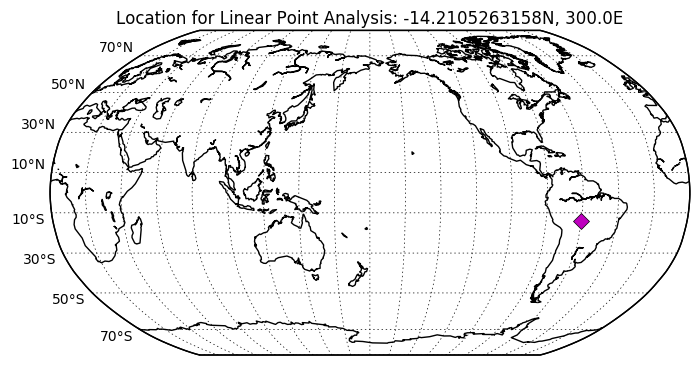

/home/disk/eos3/mlague//simple_land/scripts/python/analysis/global_pert/figures/sensitivity/map_single_point_lat-14_lon300.eps


In [8]:
# First order of business: Find the point! 

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0) # can't make it start anywhere other than 180???
mp.drawcoastlines()
mp.drawmapboundary(fill_color='1.')  # make map background white
parallels = np.arange(-90.,90,20.)
mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
meridians = np.arange(0.,360.,20.)
mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])

# North America
#idx_x = 100
#idx_y = 70

# South America
idx_x = 120
idx_y = 40

x, y = mp(idx_x,idx_y)
print(ds1.lat.values[idx_y])
print(ds1.lon.values[idx_x])
print(x)
print(y)

lon_temp = ds1.lon.values[idx_x]
lat_temp = ds1.lat.values[idx_y]
x, y = mp(lon_temp,lat_temp)
mp.plot(x,y,'D-', markersize=8, linewidth=4, color='k', markerfacecolor='m')
ttl = 'Location for Linear Point Analysis: '+np.str(lat_temp)+'N, '+np.str(lon_temp)+'E'
print(ttl)
plt.title(ttl,fontsize=12)

plt.show()
fig_name = dir_fig+'map_single_point_lat'+'%.0f' %lat_temp+'_lon'+'%.0f' %lon_temp+'.eps'
print(fig_name)
#plt.savefig(fig_name, dpi=1200, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=True, bbox_inches=None, pad_inches=0.1,
#        frameon=None)
#plt.savefig(fig_name, dpi=1200, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, 
#        transparent=True)
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches=None, 
            pad_inches=0.1,frameon=None)

Okay, now that we've identified our analysis point (again, in the end I want to apply this analysis to each point, but first I want to make some line plots to show what I'm actually doing, and that is easier to look at at a single point).

Now I'll make some plots that are basically "magnitude of land surface perturbation" along the x-axis and "magnitude of atmospheric 2m temperature response (annual mean)" along the y-axis.

For now, I'll do this on annual means (break down into DJF, MMA, JJA, SON later).

Start with albedo.

In [9]:

#idx_x = 120
#idx_y = 40
lon_temp = [ds1.lon.values[idx_x]]
lat_temp = [ds1.lat.values[idx_y]]

#------------------------------------
# setup some empty dictionaries:
atm_var = {}
prop = {}
units = {}
prop = {}
pert = {}
atm_resp = {}
ds_low = {}
ds_med = {}
ds_high = {}

#------------------------------------
# fill in data sets

# albedo:
ds_low['alb'] = ds_cam['global_a1_cv2_hc1_rs100']
ds_med['alb'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['alb'] = ds_cam['global_a3_cv2_hc1_rs100']

# roughness:
ds_low['hc'] = ds_cam['global_a2_cv2_hc0.5_rs100']
ds_med['hc'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['hc'] = ds_cam['global_a2_cv2_hc10_rs100']

# evaporative resistance:
ds_low['rs'] = ds_cam['global_a2_cv2_hc1_rs30']
ds_med['rs'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['rs'] = ds_cam['global_a2_cv2_hc1_rs200']



# atmospheric variable to evaluate:
atm_var= 'TREFHT'
units[atm_var] = ds1[atm_var].units
   
sfc_props = ['alb','hc','rs']
sfc_prop_ranges = np.array([ [0.1, 0.2, 0.3],
                  [0.5, 1, 10.],
                  [30., 100., 200.]])
print(np.shape(sfc_prop_ranges))

print(sfc_prop_ranges)

i=0
for prop in sfc_props:
    pert[prop] = np.array(sfc_prop_ranges[i,:])
    ds1 = ds_low[prop]
    ds2 = ds_med[prop]
    ds3 = ds_high[prop]
    atm_resp[prop] = np.array([ds1.mean('time')[atm_var].values[idx_y,idx_x],
            ds2.mean('time')[atm_var].values[idx_y,idx_x],
            ds3.mean('time')[atm_var].values[idx_y,idx_x]])
    i=i+1



print(prop)
print(pert)
print(atm_resp)
print(pert['alb'])




(3, 3)
[[  1.00000000e-01   2.00000000e-01   3.00000000e-01]
 [  5.00000000e-01   1.00000000e+00   1.00000000e+01]
 [  3.00000000e+01   1.00000000e+02   2.00000000e+02]]
rs
{'rs': array([  30.,  100.,  200.]), 'alb': array([ 0.1,  0.2,  0.3]), 'hc': array([  0.5,   1. ,  10. ])}
{'rs': array([ 298.29110718,  298.39749146,  299.38006592], dtype=float32), 'alb': array([ 300.19320679,  298.39749146,  296.71652222], dtype=float32), 'hc': array([ 298.4246521 ,  298.39749146,  298.42990112], dtype=float32)}
[ 0.1  0.2  0.3]


{'TREFHT': 'K'}


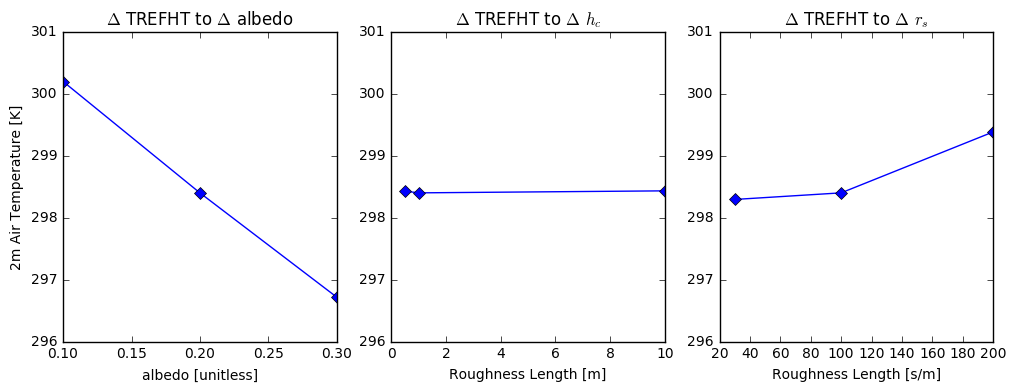

In [10]:
# Plot the response curve:
# (as a 1x3, one plot for each variable, since the horizontal axes aren't the same... )
fig, axes = plt.subplots(1, 3, figsize=(12,4))
    
lat = ds1.lat.values
lev = ds1.lev.values
    
ylim = [296,301]
print(units)

#------------------------------------------
# ALBEDO 

prop = 'alb'
ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ albedo'
plt.plot(pert[prop],atm_resp[prop],'D-')
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('albedo [unitless]')
plt.ylabel('2m Air Temperature [K]')

#------------------------------------------
# Roughness 
    
prop = 'hc'
ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $h_c$'
plt.plot(pert[prop],atm_resp[prop],'D-')
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('Roughness Length [m]')
#plt.ylabel('2m Air Temperature [K]')

#------------------------------------------
# Evaporative resistance 
    
prop = 'rs'
ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $r_s$'
plt.plot(pert[prop],atm_resp[prop],'D-')
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('Roughness Length [s/m]')
#plt.ylabel('2m Air Temperature [K]')


Well, roughness length probably isn't SUPPOSED to be linear; a logarithmic relationship would make more sense. So maybe instead of assuming linearity, we should calculate a d(log(x)) (maybe... or is it d(log(T))? ) 

Okay, Now I'm going to find the slope, assuming linearity for albedo and evaporative resistance, and assuming log-linear (plot first!) for roughness length.

{'TREFHT': 'K'}
[ -17.38342285  301.91242472]
-0.0575260700116
{'alb': -17.3834228515625}
{'alb': 301.91244506835938}
{'alb': -0.99981850037157538}
[  4.84688703e-03   2.98414748e+02]
206.317992157
{'alb': -17.3834228515625, 'hc': 0.0048468870288038424}
{'alb': 301.91244506835938, 'hc': 298.414758143857}
{'alb': -0.99981850037157538, 'hc': 0.4369619738503242}
[  6.63989341e-03   2.97959167e+02]
150.604827159
{'rs': 0.0066398934142230318, 'alb': -17.3834228515625, 'hc': 0.0048468870288038424}
{'rs': 297.95915640216987, 'alb': 301.91244506835938, 'hc': 298.414758143857}
{'rs': 0.94495239614455184, 'alb': -0.99981850037157538, 'hc': 0.4369619738503242}


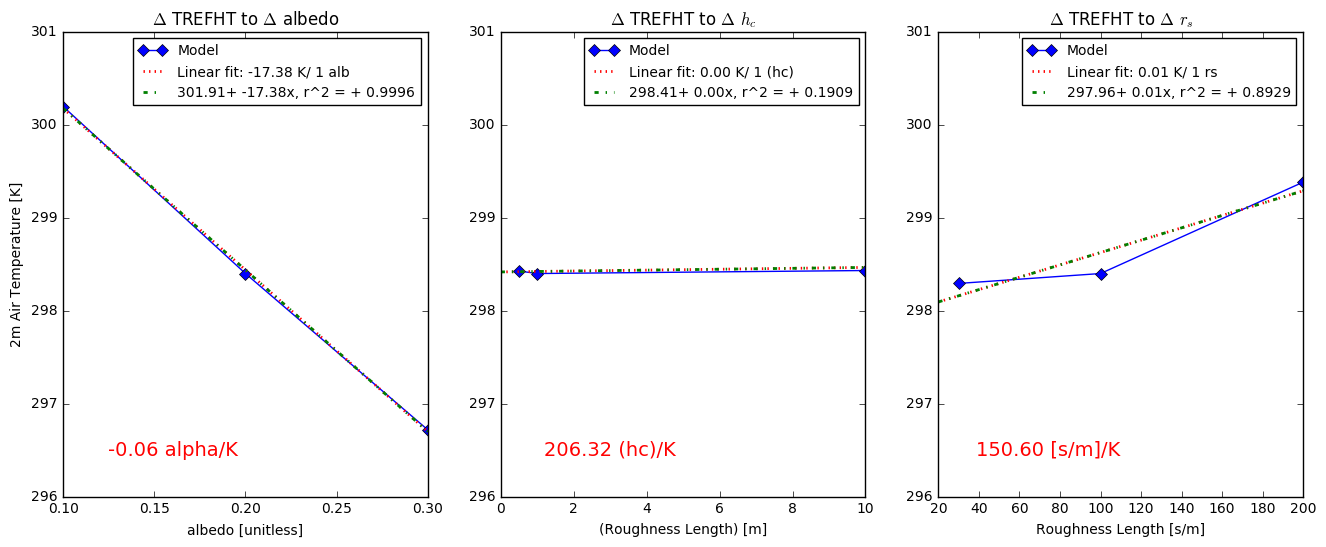

In [11]:
# Plot the response curve:
# (as a 1x3, one plot for each variable, since the horizontal axes aren't the same... )
fig, axes = plt.subplots(1, 3, figsize=(16,6))
    
lat = ds1.lat.values
lev = ds1.lev.values
    
ylim = [296,301]
print(units)

sens={}

slope = {}
intercept = {}
r_value = {}
p_value = {}
std_err = {}

#------------------------------------------
# ALBEDO 

prop = 'alb'
ax = axes.flatten()[0]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ albedo'
lbl='Model'
pdat, = plt.plot(pert[prop],atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('albedo [unitless]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit(pert[prop],atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 alb'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.3*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' alpha/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)

#------------------------------------------
# Roughness 
    
prop = 'hc'
ax = axes.flatten()[1]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $h_c$'
lbl='Model'
pdat, = plt.plot((pert[prop]),atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('(Roughness Length) [m]')
#plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit(np.log(pert[prop]),atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 (hc)'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(np.log(pert[prop]),atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)


# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.3*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' (hc)/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)


#------------------------------------------
# Evaporative resistance 
    
prop = 'rs'
ax = axes.flatten()[2]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $r_s$'
lbl = 'Model'
pdat, = plt.plot(pert[prop],atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('Roughness Length [s/m]')

# Linear fit:
p = np.polyfit(pert[prop],atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 rs'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)


# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.3*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' [s/m]/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)


Modify y limits across plots to get a better idea of shape, especially of roughness length.

{'TREFHT': 'K'}
[ -17.38342285  301.91242472]
-0.0575260700116
{'rs': 0.0066398934142230318, 'alb': -17.3834228515625, 'hc': 0.0048468870288038424}
{'rs': 297.95915640216987, 'alb': 301.91244506835938, 'hc': 298.414758143857}
{'rs': 0.94495239614455184, 'alb': -0.99981850037157538, 'hc': 0.4369619738503242}
[  1.91237558e-03   2.98410017e+02]
522.909835302
{'rs': 0.0066398934142230318, 'alb': -17.3834228515625, 'hc': 0.001912375580812682}
{'rs': 297.95915640216987, 'alb': 301.91244506835938, 'hc': 298.41002762537772}
{'rs': 0.94495239614455184, 'alb': -0.99981850037157538, 'hc': 0.58774703664293804}
[  6.63989341e-03   2.97959167e+02]
150.604827159
{'rs': 0.0066398934142230318, 'alb': -17.3834228515625, 'hc': 0.001912375580812682}
{'rs': 297.95915640216987, 'alb': 301.91244506835938, 'hc': 298.41002762537772}
{'rs': 0.94495239614455184, 'alb': -0.99981850037157538, 'hc': 0.58774703664293804}
<class 'numpy.ndarray'>


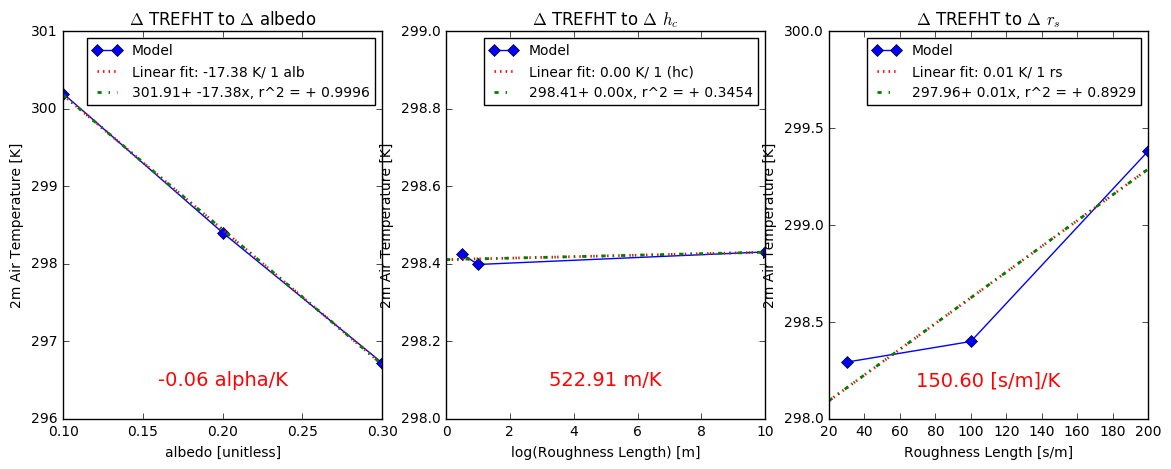

In [12]:
# Plot the response curve:
# (as a 1x3, one plot for each variable, since the horizontal axes aren't the same... )
fig, axes = plt.subplots(1, 3, figsize=(14,5))
    
lat = ds1.lat.values
lev = ds1.lev.values
    
ylim = [296,301]
print(units)

sens={}

#------------------------------------------
# ALBEDO 

prop = 'alb'
ax = axes.flatten()[0]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ albedo'
lbl='Model'
pdat, = plt.plot(pert[prop],atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('albedo [unitless]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit(pert[prop],atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 alb'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' alpha/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)

#------------------------------------------
# Roughness 
ylim = [298,299]

prop = 'hc'
ax = axes.flatten()[1]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $h_c$'
lbl='Model'
pdat, = plt.plot((pert[prop]),atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('log(Roughness Length) [m]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit((pert[prop]),atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 (hc)'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' m/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)


#------------------------------------------
# Evaporative resistance 
ylim = [298,300]

prop = 'rs'
ax = axes.flatten()[2]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $r_s$'
lbl = 'Model'
pdat, = plt.plot(pert[prop],atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('Roughness Length [s/m]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit(pert[prop],atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 rs'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' [s/m]/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)

a=  np.array(lon_temp[:])
print(type(a))
fig_name = dir_fig+'lin_regres_single_point_lat'+'%.0f' %np.array(lat_temp[:])+'_lon'+'%.0f' %np.array(lon_temp[:])+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches=None, 
            pad_inches=0.1,frameon=None)


Places with low $r^2$ values don't have strong linear relationships. See if $h_c$ always has a poor linear relationship, and consider fitting a log to it or something instead (the site I picked just above has almost no change with roughness. Other places have more response). 

Try a location in North America instead

42.6315789474
250.0
11561591.277141888
15882673.647647098
Location for Linear Point Analysis: 42.6315789474N, 250.0E


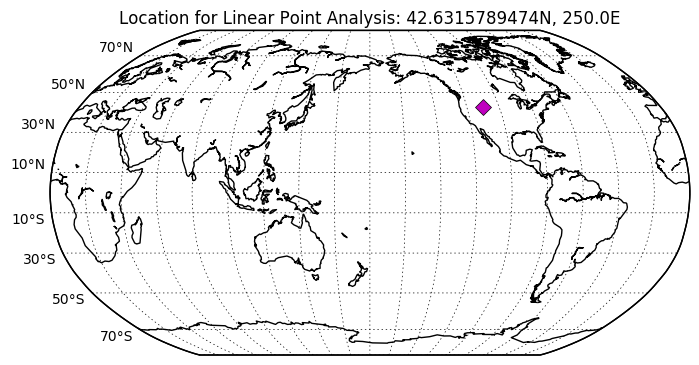

250.0


In [13]:
# First order of business: Find the point! 

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0) # can't make it start anywhere other than 180???
mp.drawcoastlines()
mp.drawmapboundary(fill_color='1.')  # make map background white
parallels = np.arange(-90.,90,20.)
mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
meridians = np.arange(0.,360.,20.)
mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])

# North America
idx_x = 100
idx_y = 70

# South America
#idx_x = 120
#idx_y = 40

x, y = mp(idx_x,idx_y)
print(ds1.lat.values[idx_y])
print(ds1.lon.values[idx_x])
print(x)
print(y)

lon_temp = ds1.lon.values[idx_x]
lat_temp = ds1.lat.values[idx_y]
x, y = mp(lon_temp,lat_temp)
mp.plot(x,y,'D-', markersize=8, linewidth=4, color='k', markerfacecolor='m')
ttl = 'Location for Linear Point Analysis: '+np.str(lat_temp)+'N, '+np.str(lon_temp)+'E'
print(ttl)
plt.title(ttl,fontsize=12)

plt.show()
print(lon_temp)
fig_name = dir_fig+'map_single_point_lat'+'%.0f' %lat_temp+'_lon'+'%.0f' %lon_temp+'.eps'
#plt.savefig(fig_name, dpi=1200, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=True, bbox_inches=None, pad_inches=0.1,
#        frameon=None)
#plt.savefig(fig_name, dpi=1200, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, 
#        transparent=True)
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches=None, 
            pad_inches=0.1,frameon=None)

In [14]:

#------------------------------------
# setup some empty dictionaries:
atm_var = {}
prop = {}
units = {}
prop = {}
pert = {}
# annual mean:
atm_resp = {}
# seasonal:
atm_resp_djf = {}
atm_resp_mam = {}
atm_resp_jja = {}
atm_resp_son = {}
# index of names
ds_low = {}
ds_med = {}
ds_high = {}

#------------------------------------
# fill in data sets

# albedo:
ds_low['alb'] = ds_cam['global_a1_cv2_hc1_rs100']
ds_med['alb'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['alb'] = ds_cam['global_a3_cv2_hc1_rs100']

# roughness:
ds_low['hc'] = ds_cam['global_a2_cv2_hc0.5_rs100']
ds_med['hc'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['hc'] = ds_cam['global_a2_cv2_hc10_rs100']

# evaporative resistance:
ds_low['rs'] = ds_cam['global_a2_cv2_hc1_rs30']
ds_med['rs'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['rs'] = ds_cam['global_a2_cv2_hc1_rs200']



# atmospheric variable to evaluate:
atm_var= 'TREFHT'
units[atm_var] = ds1[atm_var].units
   
sfc_props = ['alb','hc','rs']
sfc_prop_ranges = np.array([ [0.1, 0.2, 0.3],
                  [0.5, 1, 10.],
                  [30., 100., 200.]])
print(np.shape(sfc_prop_ranges))

print(sfc_prop_ranges)

i=0
for prop in sfc_props:
    # perturbation values
    pert[prop] = sfc_prop_ranges[i,:]
    # datasets for surface property perturbed
    ds1 = ds_low[prop]
    ds2 = ds_med[prop]
    ds3 = ds_high[prop]
    
    # annual mean response
    atm_resp[prop] = [ds1.mean('time')[atm_var].values[idx_y,idx_x],
            ds2.mean('time')[atm_var].values[idx_y,idx_x],
            ds3.mean('time')[atm_var].values[idx_y,idx_x]]
    
    # seasonal responses:
    # (first, make 12 month response, then average over djf, jja, etc)
    #print(np.shape(ds1[atm_var].values))
    resp_mths = np.array([ds1[atm_var].values[:,idx_y,idx_x],
                ds2[atm_var].values[:,idx_y,idx_x],
                ds3[atm_var].values[:,idx_y,idx_x]])
    #print(np.shape(resp_mths))
    #print(type(resp_mths))
    #print(resp_mths[:,[11,0,1]])
    atm_resp_djf[prop] = np.mean(resp_mths[:,[11,0,1]],1).squeeze()
    atm_resp_mam[prop] = np.mean(resp_mths[:,[2,3,4]],1).squeeze()
    atm_resp_jja[prop] = np.mean(resp_mths[:,[5,6,7]],1).squeeze()
    atm_resp_son[prop] = np.mean(resp_mths[:,[8,9,10]],1).squeeze()
    #print(np.shape(atm_resp_djf))
    i=i+1



print(prop)
print(pert)
print(atm_resp)
print(pert['alb'])




(3, 3)
[[  1.00000000e-01   2.00000000e-01   3.00000000e-01]
 [  5.00000000e-01   1.00000000e+00   1.00000000e+01]
 [  3.00000000e+01   1.00000000e+02   2.00000000e+02]]
rs
{'rs': array([  30.,  100.,  200.]), 'alb': array([ 0.1,  0.2,  0.3]), 'hc': array([  0.5,   1. ,  10. ])}
{'rs': [274.85855, 276.01053, 277.05597], 'alb': [278.72495, 276.01053, 273.62662], 'hc': [276.15088, 276.01053, 276.0827]}
[ 0.1  0.2  0.3]


{'TREFHT': 'K'}
[ -25.49163818  281.21902466]
-0.0392285498797
{'rs': 0.0066398934142230318, 'alb': -25.491638183593746, 'hc': 0.001912375580812682}
{'rs': 297.95915640216987, 'alb': 281.21902465820312, 'hc': 298.41002762537772}
{'rs': 0.94495239614455184, 'alb': -0.99930032826671933, 'hc': 0.58774703664293804}
[ -3.98152076e-04   2.76082896e+02]
-2511.60312849
{'rs': 0.0066398934142230318, 'alb': -25.491638183593746, 'hc': -0.00039815207612062687}
{'rs': 297.95915640216987, 'alb': 281.21902465820312, 'hc': 276.08288611290635}
{'rs': 0.94495239614455184, 'alb': -0.99930032826671933, 'hc': -0.03032935832928323}
[  1.27567030e-02   2.74571779e+02]
78.3901608561
{'rs': 0.012756702997913101, 'alb': -25.491638183593746, 'hc': -0.00039815207612062687}
{'rs': 274.57176877374519, 'alb': 281.21902465820312, 'hc': 276.08288611290635}
{'rs': 0.99162410784436905, 'alb': -0.99930032826671933, 'hc': -0.03032935832928323}


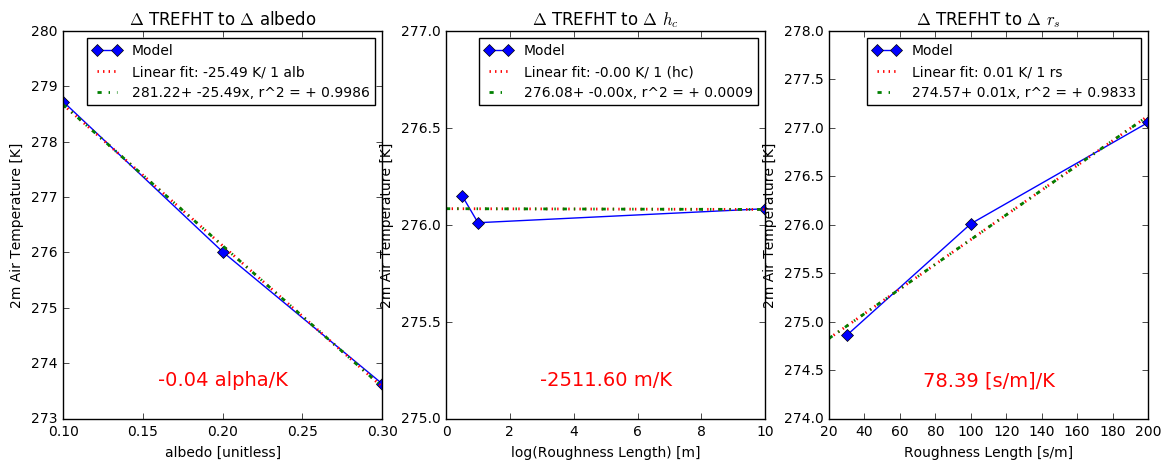

In [15]:
# Plot the response curve:
# (as a 1x3, one plot for each variable, since the horizontal axes aren't the same... )
fig, axes = plt.subplots(1, 3, figsize=(14,5))
    
lat = ds1.lat.values
lev = ds1.lev.values
    
ylim = [270,310]
print(units)

sens={}

#------------------------------------------
# ALBEDO 

ylim = [273,280]

prop = 'alb'
ax = axes.flatten()[0]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ albedo'
lbl='Model'
pdat, = plt.plot(pert[prop],atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('albedo [unitless]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit(pert[prop],atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 alb'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' alpha/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)

#------------------------------------------
# Roughness 
ylim = [275,277]

prop = 'hc'
ax = axes.flatten()[1]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $h_c$'
lbl='Model'
pdat, = plt.plot((pert[prop]),atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('log(Roughness Length) [m]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit((pert[prop]),atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 (hc)'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' m/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)


#------------------------------------------
# Evaporative resistance 
ylim = [274,278]

prop = 'rs'
ax = axes.flatten()[2]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $r_s$'
lbl = 'Model'
pdat, = plt.plot(pert[prop],atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('Roughness Length [s/m]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit(pert[prop],atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 rs'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' [s/m]/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)

fig_name = dir_fig+'lin_regres_single_point_lat'+'%.0f' %lat_temp+'_lon'+'%.0f' %lon_temp+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches=None, 
            pad_inches=0.1,frameon=None)


Am I screwing up the roughness length plot / calculation, somehow??? Or just picking really boring places?

Now try somewhere in Africa

-23.6842105263
25.0
1862979.1241056249
12354626.737141538
Location for Linear Point Analysis: -23.6842105263N, 25.0E


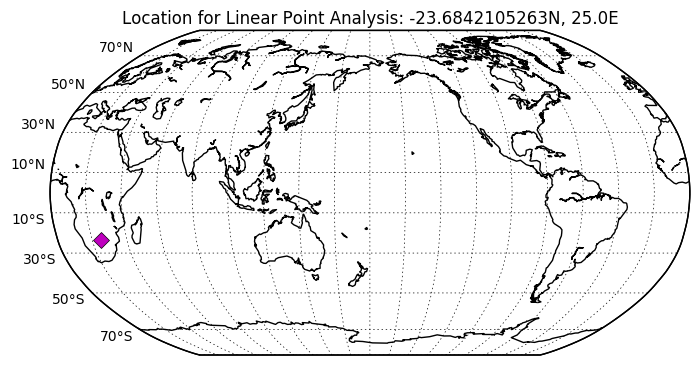

25.0


In [16]:
# First order of business: Find the point! 

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0) # can't make it start anywhere other than 180???
mp.drawcoastlines()
mp.drawmapboundary(fill_color='1.')  # make map background white
parallels = np.arange(-90.,90,20.)
mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
meridians = np.arange(0.,360.,20.)
mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])

# 
idx_x = 10
idx_y = 35


x, y = mp(idx_x,idx_y)
print(ds1.lat.values[idx_y])
print(ds1.lon.values[idx_x])
print(x)
print(y)

lon_temp = ds1.lon.values[idx_x]
lat_temp = ds1.lat.values[idx_y]
x, y = mp(lon_temp,lat_temp)
mp.plot(x,y,'D-', markersize=8, linewidth=4, color='k', markerfacecolor='m')
ttl = 'Location for Linear Point Analysis: '+np.str(lat_temp)+'N, '+np.str(lon_temp)+'E'
print(ttl)
plt.title(ttl,fontsize=12)

plt.show()
print(lon_temp)
fig_name = dir_fig+'map_single_point_lat'+'%.0f' %lat_temp+'_lon'+'%.0f' %lon_temp+'.eps'
#plt.savefig(fig_name, dpi=1200, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=True, bbox_inches=None, pad_inches=0.1,
#        frameon=None)
#plt.savefig(fig_name, dpi=1200, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, 
#        transparent=True)
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches=None, 
            pad_inches=0.1,frameon=None)

In [17]:

#------------------------------------
# setup some empty dictionaries:
atm_var = {}
prop = {}
units = {}
prop = {}
pert = {}
atm_resp = {}
ds_low = {}
ds_med = {}
ds_high = {}

#------------------------------------
# fill in data sets

# albedo:
ds_low['alb'] = ds_cam['global_a1_cv2_hc1_rs100']
ds_med['alb'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['alb'] = ds_cam['global_a3_cv2_hc1_rs100']

# roughness:
ds_low['hc'] = ds_cam['global_a2_cv2_hc0.5_rs100']
ds_med['hc'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['hc'] = ds_cam['global_a2_cv2_hc10_rs100']

# evaporative resistance:
ds_low['rs'] = ds_cam['global_a2_cv2_hc1_rs30']
ds_med['rs'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['rs'] = ds_cam['global_a2_cv2_hc1_rs200']



# atmospheric variable to evaluate:
atm_var= 'TREFHT'
units[atm_var] = ds1[atm_var].units
   
sfc_props = ['alb','hc','rs']
sfc_prop_ranges = np.array([ [0.1, 0.2, 0.3],
                  [0.5, 1, 10.],
                  [30., 100., 200.]])
print(np.shape(sfc_prop_ranges))

print(sfc_prop_ranges)

i=0
for prop in sfc_props:
    pert[prop] = sfc_prop_ranges[i,:]
    ds1 = ds_low[prop]
    ds2 = ds_med[prop]
    ds3 = ds_high[prop]
    atm_resp[prop] = [ds1.mean('time')[atm_var].values[idx_y,idx_x],
            ds2.mean('time')[atm_var].values[idx_y,idx_x],
            ds3.mean('time')[atm_var].values[idx_y,idx_x]]
    i=i+1



print(prop)
print(pert)
print(atm_resp)
print(pert['alb'])




(3, 3)
[[  1.00000000e-01   2.00000000e-01   3.00000000e-01]
 [  5.00000000e-01   1.00000000e+00   1.00000000e+01]
 [  3.00000000e+01   1.00000000e+02   2.00000000e+02]]
rs
{'rs': array([  30.,  100.,  200.]), 'alb': array([ 0.1,  0.2,  0.3]), 'hc': array([  0.5,   1. ,  10. ])}
{'rs': [292.39374, 293.14407, 292.92468], 'alb': [293.83044, 293.14407, 291.64523], 'hc': [293.15402, 293.14407, 292.75119]}
[ 0.1  0.2  0.3]


{'TREFHT': 'K'}
[ -10.92605591  295.05846151]
-0.0915243348928
{'rs': 0.012756702997913101, 'alb': -10.926055908203125, 'hc': -0.00039815207612062687}
{'rs': 274.57176877374519, 'alb': 295.0584716796875, 'hc': 276.08288611290635}
{'rs': 0.99162410784436905, 'alb': -0.97772718898409683, 'hc': -0.03032935832928323}
[ -4.29610984e-02   2.93181113e+02]
-23.2768722896
{'rs': 0.012756702997913101, 'alb': -10.926055908203125, 'hc': -0.042961098362336005}
{'rs': 274.57176877374519, 'alb': 295.0584716796875, 'hc': 293.18113318499832}
{'rs': 0.99162410784436905, 'alb': -0.97772718898409683, 'hc': -0.99968436365473534}
[  2.75901899e-03   2.92517339e+02]
362.447668472
{'rs': 0.0027590189894584763, 'alb': -10.926055908203125, 'hc': -0.042961098362336005}
{'rs': 292.51733920998771, 'alb': 295.0584716796875, 'hc': 293.18113318499832}
{'rs': 0.61102175741285214, 'alb': -0.97772718898409683, 'hc': -0.99968436365473534}


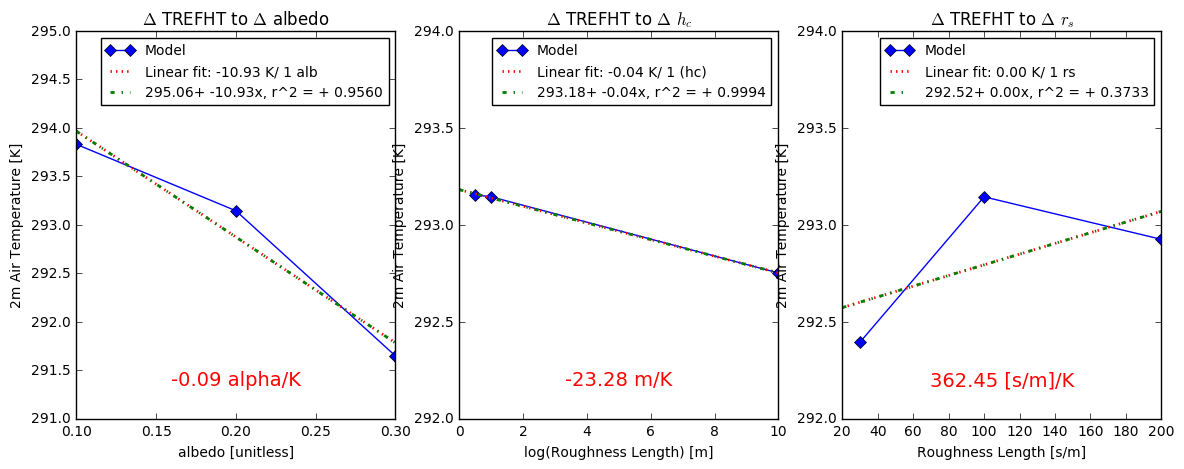

In [18]:
# Plot the response curve:
# (as a 1x3, one plot for each variable, since the horizontal axes aren't the same... )
fig, axes = plt.subplots(1, 3, figsize=(14,5))
    
lat = ds1.lat.values
lev = ds1.lev.values
    
ylim = [270,310]
print(units)

sens={}

#------------------------------------------
# ALBEDO 
ylim = [291,295]

prop = 'alb'
ax = axes.flatten()[0]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ albedo'
lbl='Model'
pdat, = plt.plot(pert[prop],atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('albedo [unitless]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit(pert[prop],atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 alb'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' alpha/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)

#------------------------------------------
# Roughness 
ylim = [292,294]

prop = 'hc'
ax = axes.flatten()[1]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $h_c$'
lbl='Model'
pdat, = plt.plot((pert[prop]),atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('log(Roughness Length) [m]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit((pert[prop]),atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 (hc)'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' m/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)


#------------------------------------------
# Evaporative resistance 
ylim = [292,294]

prop = 'rs'
ax = axes.flatten()[2]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $r_s$'
lbl = 'Model'
pdat, = plt.plot(pert[prop],atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('Roughness Length [s/m]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit(pert[prop],atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 rs'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' [s/m]/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)

fig_name = dir_fig+'lin_regres_single_point_lat'+'%.0f' %lat_temp+'_lon'+'%.0f' %lon_temp+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches=None, 
            pad_inches=0.1,frameon=None)


19.8947368421
25.0
3935758.0854286477
14747401.798121855
Location for Linear Point Analysis: 19.8947368421N, 25.0E


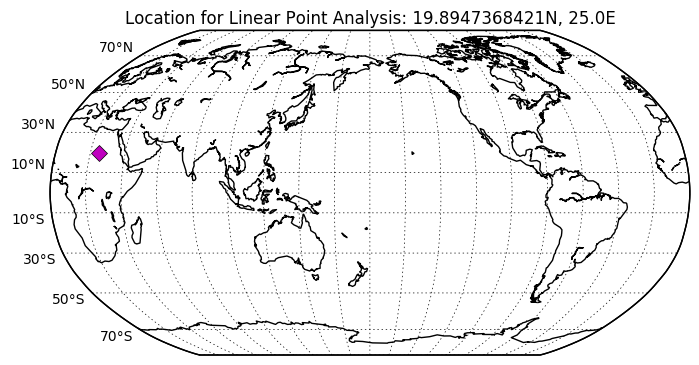

25.0


In [19]:
# First order of business: Find the point! 

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0) # can't make it start anywhere other than 180???
mp.drawcoastlines()
mp.drawmapboundary(fill_color='1.')  # make map background white
parallels = np.arange(-90.,90,20.)
mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
meridians = np.arange(0.,360.,20.)
mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])

# 
idx_x = 10
idx_y = 58


x, y = mp(idx_x,idx_y)
print(ds1.lat.values[idx_y])
print(ds1.lon.values[idx_x])
print(x)
print(y)

lon_temp = ds1.lon.values[idx_x]
lat_temp = ds1.lat.values[idx_y]
x, y = mp(lon_temp,lat_temp)
mp.plot(x,y,'D-', markersize=8, linewidth=4, color='k', markerfacecolor='m')
ttl = 'Location for Linear Point Analysis: '+np.str(lat_temp)+'N, '+np.str(lon_temp)+'E'
print(ttl)
plt.title(ttl,fontsize=12)

plt.show()
print(lon_temp)
fig_name = dir_fig+'map_single_point_lat'+'%.0f' %lat_temp+'_lon'+'%.0f' %lon_temp+'.eps'
#plt.savefig(fig_name, dpi=1200, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=True, bbox_inches=None, pad_inches=0.1,
#        frameon=None)
#plt.savefig(fig_name, dpi=1200, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, 
#        transparent=True)
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches=None, 
            pad_inches=0.1,frameon=None)

In [20]:

#------------------------------------
# setup some empty dictionaries:
atm_var = {}
prop = {}
units = {}
prop = {}
pert = {}
atm_resp = {}
ds_low = {}
ds_med = {}
ds_high = {}

#------------------------------------
# fill in data sets

# albedo:
ds_low['alb'] = ds_cam['global_a1_cv2_hc1_rs100']
ds_med['alb'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['alb'] = ds_cam['global_a3_cv2_hc1_rs100']

# roughness:
ds_low['hc'] = ds_cam['global_a2_cv2_hc0.5_rs100']
ds_med['hc'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['hc'] = ds_cam['global_a2_cv2_hc10_rs100']

# evaporative resistance:
ds_low['rs'] = ds_cam['global_a2_cv2_hc1_rs30']
ds_med['rs'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['rs'] = ds_cam['global_a2_cv2_hc1_rs200']



# atmospheric variable to evaluate:
atm_var= 'TREFHT'
units[atm_var] = ds1[atm_var].units
   
sfc_props = ['alb','hc','rs']
sfc_prop_ranges = np.array([ [0.1, 0.2, 0.3],
                  [0.5, 1, 10.],
                  [30., 100., 200.]])
print(np.shape(sfc_prop_ranges))

print(sfc_prop_ranges)

i=0
for prop in sfc_props:
    pert[prop] = sfc_prop_ranges[i,:]
    ds1 = ds_low[prop]
    ds2 = ds_med[prop]
    ds3 = ds_high[prop]
    atm_resp[prop] = [ds1.mean('time')[atm_var].values[idx_y,idx_x],
            ds2.mean('time')[atm_var].values[idx_y,idx_x],
            ds3.mean('time')[atm_var].values[idx_y,idx_x]]
    i=i+1



print(prop)
print(pert)
print(atm_resp)
print(pert['alb'])




(3, 3)
[[  1.00000000e-01   2.00000000e-01   3.00000000e-01]
 [  5.00000000e-01   1.00000000e+00   1.00000000e+01]
 [  3.00000000e+01   1.00000000e+02   2.00000000e+02]]
rs
{'rs': array([  30.,  100.,  200.]), 'alb': array([ 0.1,  0.2,  0.3]), 'hc': array([  0.5,   1. ,  10. ])}
{'rs': [298.08218, 298.15695, 298.88708], 'alb': [300.3533, 298.15695, 296.49899], 'hc': [298.7067, 298.15695, 297.86166]}
[ 0.1  0.2  0.3]


{'TREFHT': 'K'}
[ -19.27154541  302.19072469]
-0.0518899745047
{'rs': 0.0027590189894584763, 'alb': -19.27154541015625, 'hc': -0.042961098362336005}
{'rs': 292.51733920998771, 'alb': 302.19073486328125, 'hc': 293.18113318499832}
{'rs': 0.61102175741285214, 'alb': -0.99676377107809055, 'hc': -0.99968436365473534}
[ -6.39082572e-02   2.98486752e+02]
-15.647430293
{'rs': 0.0027590189894584763, 'alb': -19.27154541015625, 'hc': -0.063908257220298831}
{'rs': 292.51733920998771, 'alb': 302.19073486328125, 'hc': 298.48677242416221}
{'rs': 0.61102175741285214, 'alb': -0.99676377107809055, 'hc': -0.79671773796486989}
[  4.91050825e-03   2.97835251e+02]
203.644907949
{'rs': 0.0049105082472709763, 'alb': -19.27154541015625, 'hc': -0.063908257220298831}
{'rs': 297.83524082131584, 'alb': 302.19073486328125, 'hc': 298.48677242416221}
{'rs': 0.94345330882115142, 'alb': -0.99676377107809055, 'hc': -0.79671773796486989}


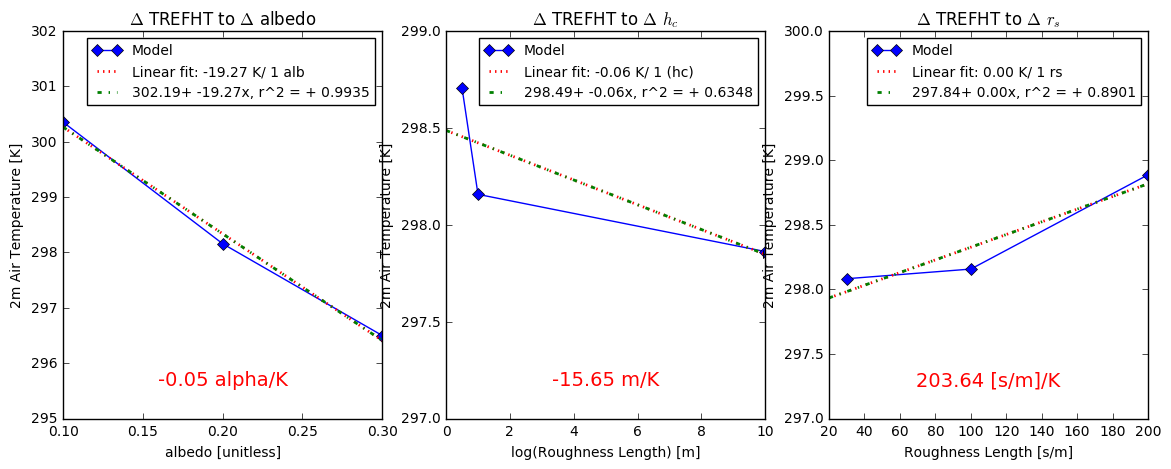

In [21]:
# Plot the response curve:
# (as a 1x3, one plot for each variable, since the horizontal axes aren't the same... )
fig, axes = plt.subplots(1, 3, figsize=(14,5))
    
lat = ds1.lat.values
lev = ds1.lev.values
    
ylim = [270,310]
print(units)

sens={}

#------------------------------------------
# ALBEDO 
ylim = [295,302]

prop = 'alb'
ax = axes.flatten()[0]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ albedo'
lbl='Model'
pdat, = plt.plot(pert[prop],atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('albedo [unitless]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit(pert[prop],atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 alb'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' alpha/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)

#------------------------------------------
# Roughness 
ylim = [297,299]

prop = 'hc'
ax = axes.flatten()[1]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $h_c$'
lbl='Model'
pdat, = plt.plot((pert[prop]),atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('log(Roughness Length) [m]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit((pert[prop]),atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 (hc)'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' m/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)


#------------------------------------------
# Evaporative resistance 
ylim = [297,300]

prop = 'rs'
ax = axes.flatten()[2]
plt.sca(ax)
ttl = '$\Delta$ ' + atm_var + ' to $\Delta$ $r_s$'
lbl = 'Model'
pdat, = plt.plot(pert[prop],atm_resp[prop],'D-',label=lbl)
plt.ylim(ylim)
plt.title(ttl)
plt.xlabel('Roughness Length [s/m]')
plt.ylabel('2m Air Temperature [K]')

# Linear fit:
p = np.polyfit(pert[prop],atm_resp[prop],deg=1)
print(p)
print(1/p[0])
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = p[0]*x+p[1]
lbl = 'Linear fit: ' + '%.2f' % p[0] + ' K/ 1 rs'
pfit, = plt.plot(x,y,'r:',linewidth=2.0,label=lbl)
plt.xlim(xs)

# Linear regression
slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
print(slope)
print(intercept)
print(r_value)
xs = ax.get_xlim()
x = np.linspace(xs[0],xs[1],num=20)
y = intercept[prop]+x*slope[prop]
lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)

# inverse slope, how much var it takes for a 1K warming
sens[prop] = 1/p[0]
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.1*(bottom+top), '%.2f' % sens[prop] + ' [s/m]/K',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14, color='red',
        transform=ax.transAxes)

# legend:
plt.legend(handles=[pdat, pfit,plin],fontsize=10)

fig_name = dir_fig+'lin_regres_single_point_lat'+'%.0f' %lat_temp+'_lon'+'%.0f' %lon_temp+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches=None, 
            pad_inches=0.1,frameon=None)


# Maps of atmospheric sensitivity of surface perturbation

I'll start with just doing albedo and evaporative resistance, because I need to think a little more about how to deal with the log relationship in roughness. And we probably want to run a hc=2m simulation.



Do the same "regression" to each land point on the earth, calculate the inverse slope (how much of a $\Delta$ surface property is required for a 1 K warming of the 2m air temperature? ... assumes local effect.) 


### Global Response deltas
Calculate the 2m air temperature for each perturbed simulation, in matrix lat x lon form.

In [22]:

#------------------------------------
# setup some empty dictionaries:
atm_var = {}
prop = {}
units = {}
prop = {}
pert = {}
# annual mean:
atm_resp = {}
# seasonal:
atm_resp_djf = {}
atm_resp_mam = {}
atm_resp_jja = {}
atm_resp_son = {}
# data sets
ds_low = {}
ds_med = {}
ds_high = {}

#------------------------------------
# fill in data sets

# albedo:
ds_low['alb'] = ds_cam['global_a1_cv2_hc1_rs100']
ds_med['alb'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['alb'] = ds_cam['global_a3_cv2_hc1_rs100']

# roughness:
ds_low['hc'] = ds_cam['global_a2_cv2_hc0.5_rs100']
ds_med['hc'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['hc'] = ds_cam['global_a2_cv2_hc10_rs100']

# evaporative resistance:
ds_low['rs'] = ds_cam['global_a2_cv2_hc1_rs30']
ds_med['rs'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['rs'] = ds_cam['global_a2_cv2_hc1_rs200']


# atmospheric variable to evaluate:
atm_var= 'TREFHT'
units[atm_var] = ds1[atm_var].units
   
sfc_props = ['alb','hc','rs']
sfc_prop_ranges = np.array([ [0.1, 0.2, 0.3],
                  [0.5, 1, 10.],
                  [30., 100., 200.]])
print(np.shape(sfc_prop_ranges))

print(sfc_prop_ranges)

i=0

for prop in sfc_props:
    pert[prop] = sfc_prop_ranges[i,:]
    ds1 = ds_low[prop]
    ds2 = ds_med[prop]
    ds3 = ds_high[prop]
    
    # annual mean response
    atm_resp[prop] = [ds1.mean('time')[atm_var].values[:,:],
            ds2.mean('time')[atm_var].values[:,:],
            ds3.mean('time')[atm_var].values[:,:]]
    
    # seasonal responses:
    # (first, make 12 month response, then average over djf, jja, etc)
    #print(np.shape(ds1[atm_var].values))
    resp_mths = np.array([ds1[atm_var].values[:,:,:],
                ds2[atm_var].values[:,:,:],
                ds3[atm_var].values[:,:,:]])
    print(np.shape(resp_mths))
    #print(type(resp_mths))
    #print(resp_mths[:,[11,0,1]])
    atm_resp_djf[prop] = np.mean(resp_mths[:,[11,0,1],:,:],1).squeeze()
    atm_resp_mam[prop] = np.mean(resp_mths[:,[2,3,4],:,:],1).squeeze()
    atm_resp_jja[prop] = np.mean(resp_mths[:,[5,6,7],:,:],1).squeeze()
    atm_resp_son[prop] = np.mean(resp_mths[:,[8,9,10],:,:],1).squeeze()
    print(np.shape(atm_resp_djf[prop]))
    i=i+1

print(np.shape(atm_resp[prop]))
#print(np.shape(atm_resp['alb']))
#print(np.shape(atm_resp['rs']))

# first entry is low perturbation, second is medium, third is high.

(3, 3)
[[  1.00000000e-01   2.00000000e-01   3.00000000e-01]
 [  5.00000000e-01   1.00000000e+00   1.00000000e+01]
 [  3.00000000e+01   1.00000000e+02   2.00000000e+02]]
(3, 12, 96, 144)
(3, 96, 144)
(3, 12, 96, 144)
(3, 96, 144)
(3, 12, 96, 144)
(3, 96, 144)
(3, 96, 144)


### Regression

Now do the regression across the low/med/high perturbations for each of the 3 variables perturbed.
Shape of atm_resp is 3 x 96 x 144
where the size 3 dimension is 1=low 2=med 3=high perturbation. Probably a sleeker dicitonary way to do this, but should make the regression step more straight-forward. I think/hope.

In [23]:
# Linear regression

slope = {}
intercept = {}
r_value = {}
p_value = {}
std_err = {}

sensitivity = {}

for prop in sfc_props:
    
    slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
    
    
    
    print(slope)
    print(intercept)
    print(r_value)
    xs = ax.get_xlim()
    x = np.linspace(xs[0],xs[1],num=20)
    y = intercept[prop]+x*slope[prop]
    lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
    plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)
    
    # size of surface change required for 1K change in 2m air temperature
    sensitivity[prop] = slope[prop]**(-1)  
    



ValueError: all the input arrays must have same number of dimensions

In [ ]:
# sklearn linear_model , pearson r

# Linear regression

slope = {}
intercept = {}
r_value = {}
p_value = {}
std_err = {}

sensitivity = {}

for prop in sfc_props:
    
    #-----------------------------
    #  Do the regression
    #-----------------------------
    
    # Get the perturbation values, make an np.array (default is list)
    xvals = np.array(pert[prop])
    k = np.size(xvals)
    print(k)
    
    # grab atmospheric response data for current property, make an np.array
    raw_data = np.array(atm_resp[prop])
    # flatten response data into a single long vector (Thanks to Andre for showing me how to do this whole section)
    raw_data_v = raw_data.reshape(k, -1)
    
    
    # create an "empty" model
    model = linear_model.LinearRegression()
    
    # Fit the model to tmp_data
    model.fit(xvals[:, None], raw_data_v)
    
    #  grab the linear fit vector
    slope_vector = model.coef_
    intercept_vector = model.intercept_
    
    # put back into lat/lon (hard coded to be 2.5 degrees right now...)
    slope[prop] = slope_vector.reshape(96,144)
    intercept[prop] = intercept_vector.reshape(96,144)
    
    #-----------------------------
    #   Calculate the r^2 value
    #-----------------------------

    # grab the linear fit using the slope and intercept, so we can calculate the correlation coefficient
    fit_data_v = np.transpose(slope_vector*xvals)
    #print(np.shape(fit_data_v))
    #print(np.shape(raw_data_v))
 
    # Calculate r value
    #r_v, p_v = stats.pearsonr(raw_data_v, fit_data_v)
    %%timeit
    #r_v = np.corrcoef(x=raw_data_v,y=fit_data_v,rowvar=0)
    
    # Going to do this by hand until I figure out how to do it on a matrix...
    #print(np.size(raw_data_v,1))
    x_bar = np.mean(xvals)
    std_x = stats.tstd(xvals)
    #print(x_bar)
    #print(std_x)
    
    #print((np.shape(raw_data_v[1,:])))
    #print(np.shape(raw_data_v))
    #print(np.shape(fit_data_v))
    r_v = np.zeros(np.shape(raw_data_v[0,:]))
    p_v = np.zeros(np.shape(raw_data_v[0,:]))
    #print(np.shape(r_v))
    
    for j in range(np.size(raw_data_v,1)):
       
        # compare to using the pearson-r function:
        r, p = stats.pearsonr(raw_data_v[:,j],fit_data_v[:,j])
        r_v[j] = r
        p_v[j] = p

  
    #print(np.shape(r_v.reshape(96,144)))
    
    r_value[prop] = r_v.reshape(96,144)
    p_value[prop] = p_v.reshape(96,144)



In [ ]:
plt.imshow(r_value['alb'])
plt.colorbar()

In [ ]:

cmap =  plt.cm.viridis
cmap.set_bad('white',1.)

plt.imshow(np.array(slope['alb']))
plt.colorbar()

Well that was rather too hard... but now I should have the slope and the r value on a map (CHECK IF THEY'RE RIGHT AGAINS POINT PLOTS), for each simulation. 

# Plot maps of sensitivity
(and r^2)

I'll plot 1 x 3 maps, setup in as the following:

  inverse slope  |   slope   | r^2
  
Where:
- inverse slope is the magnitude of land change required to drive a 1K change in atm temperature
- slope is the (calculated above) slope of the delta atm / delta land, ie per 1 increment change in land property, how much change in 2m air temperature do you get?
- r^2 is the square of the r value calculated above.


In [ ]:
ds = ds_clm['global_a2_cv2_hc1_rs100']
lat = ds['lat'].values
lon = ds['lon'].values
landmask = ds['landmask'].values
landmask_nan = np.where(landmask==1,landmask,np.nan)
ocnmask_nan = landmask_nan.copy
ocnmask_nan = np.where(landmask==1,np.nan,1)

LN,LT = np.meshgrid(lon,lat)

# Get a glacier mask, too!
temp = np.mean(ds.mean('time')['MML_cv'].values[:],0)
print(np.shape(temp))
#plt.imshow(temp)
#plt.colorbar()
temp2 = temp.copy()
is_glc = np.where(temp2>1950000,np.nan,1)*landmask_nan
no_glc = np.where(temp2>1950000,1,np.nan)


ocn_glc_mask = ocnmask_nan.copy()
ocn_glc_mask = np.where(np.isnan(is_glc)==False,1,ocn_glc_mask)

bareground_mask = ocn_glc_mask.copy()
bareground_mask = np.where(np.isnan(ocn_glc_mask),1,np.nan)

plt.imshow(bareground_mask)
plt.colorbar()


In [ ]:

cmap =  plt.cm.viridis
cmap.set_bad([.3, .3, .3],alpha=1.)
cmap.set_bad('m',alpha=1.)

plt.imshow(np.array(slope['alb'])*landmask_nan)
plt.colorbar()

In [ ]:
cmap =  plt.cm.viridis
cmap.set_bad([.3, .3, .3],alpha=1.)
cmap.set_bad('m',alpha=1.)

plt.imshow(np.array(slope['alb'])*ocnmask_nan)
plt.colorbar()

In [ ]:
print(landmask_nan)

### Albedo

#### unmasked:

In [ ]:
prop = 'alb'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']

mapdata_slope = slope[prop]
mapdata_inv = slope[prop]**(-1)
mapdata_r2 = r_value[prop]**2


ttl_main = 'Albedo'
filename = 'sens_slopes_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\delta$ '+prop+' per 1K change in T2m'
units = 'unitless'
clim_diff = [-.1,.1]
mapdata = mapdata_inv
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\delta$ T2m per unit change in '+prop
units = 'K'
clim_diff = [-20,20]
clim_abs = clim_diff
mapdata = mapdata_slope
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'r^2'
units = 'r^2'
clim_abs = [0.5,1]
mapdata = mapdata_r2
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


#### land mask

In [ ]:
prop = 'alb'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']

mapdata_slope = slope[prop]
mapdata_inv = slope[prop]**(-1)
mapdata_r2 = r_value[prop]**2


ttl_main = 'Albedo'
filename = 'sens_slopes_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\delta$ '+prop+' per 1K change in T2m'
units = 'unitless'
clim_diff = [-.1,.1]
mapdata = mapdata_inv*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\delta$ T2m per unit change in '+prop
units = 'K'
clim_diff = [-20,20]
clim_abs = clim_diff
mapdata = mapdata_slope*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'r^2'
units = 'r^2'
clim_abs = [0.5,1]
mapdata = mapdata_r2*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


#### ocn mask

In [ ]:
prop = 'alb'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']

mapdata_slope = slope[prop]
mapdata_inv = slope[prop]**(-1)
mapdata_r2 = r_value[prop]**2


ttl_main = 'Albedo'
filename = 'sens_slopes_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\delta$ '+prop+' per 1K change in T2m'
units = 'unitless'
clim_diff = [-.1,.1]
mapdata = mapdata_inv*ocn_glc_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\delta$ T2m per unit change in '+prop
units = 'K'
clim_diff = [-20,20]
clim_abs = clim_diff
mapdata = mapdata_slope*ocn_glc_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'r^2'
units = 'r^2'
clim_abs = [0.5,1]
mapdata = mapdata_r2*ocn_glc_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


### Roughness

#### unmasked

In [ ]:
prop = 'hc'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']

mapdata_slope = slope[prop]
mapdata_inv = slope[prop]**(-1)
mapdata_r2 = r_value[prop]**2


ttl_main = 'Roughness'
filename = 'sens_slopes_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\delta$ '+prop+' per 0.1 K change in T2m'
units = 'm'
clim_diff = [-10,10]
mapdata = mapdata_inv*0.1
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\delta$ T2m per unit change in '+prop
units = 'K'
clim_diff = [-.2,.2]
clim_abs = clim_diff
mapdata = mapdata_slope
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'r^2'
units = 'r^2'
clim_abs = [0.5,1]
mapdata = mapdata_r2
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


#### masked

In [ ]:
prop = 'hc'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']

mapdata_slope = slope[prop]
mapdata_inv = slope[prop]**(-1)
mapdata_r2 = r_value[prop]**2


ttl_main = 'Roughness'
filename = 'sens_slopes_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\delta$ '+prop+' per 0.1 K change in T2m'
units = 'm'
clim_diff = [-10,10]
mapdata = mapdata_inv*0.1*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\delta$ T2m per unit change in '+prop
units = 'K'
clim_diff = [-.2,.2]
clim_abs = clim_diff
mapdata = mapdata_slope*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'r^2'
units = 'r^2'
clim_abs = [0.5,1]
mapdata = mapdata_r2*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


#### ocn mask

In [ ]:
prop = 'hc'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']

mapdata_slope = slope[prop]
mapdata_inv = slope[prop]**(-1)
mapdata_r2 = r_value[prop]**2


ttl_main = 'Roughness'
filename = 'sens_slopes_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\delta$ '+prop+' per 0.1 K change in T2m'
units = 'm'
clim_diff = [-10,10]
mapdata = mapdata_inv*0.1*ocn_glc_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\delta$ T2m per unit change in '+prop
units = 'K'
clim_diff = [-.2,.2]
clim_abs = clim_diff
mapdata = mapdata_slope*ocn_glc_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'r^2'
units = 'r^2'
clim_abs = [0.5,1]
mapdata = mapdata_r2*ocn_glc_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


### Evaporative Resistance

#### unmasked

In [ ]:
prop = 'rs'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']

mapdata_slope = slope[prop]
mapdata_inv = slope[prop]**(-1)
mapdata_r2 = r_value[prop]**2


ttl_main = 'Evaporative Resistance'
filename = 'sens_slopes_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\delta$ '+prop+' per 0.1K change in T2m'
units = 's/m'
clim_diff = [-100,100]
mapdata = mapdata_inv*0.1
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\delta$ T2m per unit change in '+prop
units = 'K'
clim_diff = [-.025,.025]
clim_abs = clim_diff
mapdata = mapdata_slope
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'r^2'
units = 'r^2'
clim_abs = [0.5,1]
mapdata = mapdata_r2
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


#### masked

In [ ]:
prop = 'rs'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']

mapdata_slope = slope[prop]
mapdata_inv = slope[prop]**(-1)
mapdata_r2 = r_value[prop]**2


ttl_main = 'Evaporative Resistance'
filename = 'sens_slopes_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\delta$ '+prop+' per 0.1K change in T2m'
units = 's/m'
clim_diff = [-50,50]
mapdata = mapdata_inv*0.1*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\delta$ T2m per unit change in '+prop
units = 'K'
clim_diff = [-.025,.025]
clim_abs = clim_diff
mapdata = mapdata_slope*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'r^2'
units = 'r^2'
clim_abs = [0.5,1]
mapdata = mapdata_r2*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


In [ ]:
prop = 'rs'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']

mapdata_slope = slope[prop]
mapdata_inv = slope[prop]**(-1)
mapdata_r2 = r_value[prop]**2


ttl_main = 'Evaporative Resistance'
filename = 'sens_slopes_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\delta$ '+prop+' per 0.1K change in T2m'
units = 's/m'
clim_diff = [-50,50]
mapdata = mapdata_inv*0.1*ocn_glc_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\delta$ T2m per unit change in '+prop
units = 'K'
clim_diff = [-.025,.025]
clim_abs = clim_diff
mapdata = mapdata_slope*ocn_glc_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'r^2'
units = 'r^2'
clim_abs = [0.5,1]
mapdata = mapdata_r2*ocn_glc_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


In [ ]:
tmp_data = np.array(atm_resp['alb'])

In [ ]:
tmp_data.shape

In [ ]:
# flatten spatial
tmp_data = tmp_data.reshape(3, -1)
tmp_data.shape

In [ ]:
model = linear_model.LinearRegression()

In [ ]:
%%timeit
#model.fit(np.array([30., 100., 200.])[:, None], tmp_data)
model.fit(np.array([0.1,0.2,0.3])[:, None], tmp_data)

In [ ]:
#%%timeit
#model.fit(np.array([30., 100., 200.])[:, None], tmp_data)
#for i in range(tmp_data.shape[1]):
#    model.fit(np.array([0.1,0.2,0.3])[:, None], tmp_data[:,i:i+1])

In [ ]:
temp = model.coef_

In [ ]:
temp2 = temp.reshape(96,144)


In [ ]:
plt.imshow(temp2)

#plt.clim([0,0.1])
plt.colorbar()





In [ ]:
plt.imshow(temp2*landmask)
plt.colorbar()

In [ ]:
plt.imshow((temp2)*landmask)
plt.colorbar()


In [ ]:
print(np.shape(temp2))
print(np.shape(LN))

landfrac = ds1.mean('time')['LANDFRAC'].values[:]
landmask = np.zeros(np.shape(landfrac))
landmask = np.where(landfrac==0,np.nan,1.0)
print(landmask)
plt.imshow(temp2*landmask)

mapdata = temp2;
# check against the line plots above
# e.g. Africa point:
print(temp2[idx_y,idx_x])
print('-19.27')

temp3 = temp2*(0.1)
print((temp2[idx_y,idx_x])**(-1))
print('-0.05')
print(temp3[idx_y,idx_x])

LN,LT = np.meshgrid(lon,lat)
#mapdata = temp2*landmask
mapdata = np.where(np.isnan(landmask),0,mapdata)
print(np.max(mapdata))
ds0 = ds1
myvar = 'TREFHT'
clim_diff = [-25,25]
clim_abs = [-15,15]
clim_diff = [-0.1,0.1]
units = 'albedo/K'
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r
#cmap_diff = plt.cm.jet

ttl = 'Change in T2m per 0.1 delta albedo'

mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r



In [ ]:
print(np.shape(temp2))
print(np.shape(LN))

landfrac = ds1.mean('time')['LANDFRAC'].values[:]
landmask = np.zeros(np.shape(landfrac))
landmask = np.where(landfrac==0,np.nan,1.0)
print(landmask)
plt.imshow(temp2*landmask)

mapdata = temp2**(-1);
# check against the line plots above
# e.g. Africa point:
print(temp2[idx_y,idx_x])
print('-19.27')

temp3 = temp2**(-1)
print((temp2[idx_y,idx_x])**(-1))
print('-0.05')
print(temp3[idx_y,idx_x])

LN,LT = np.meshgrid(lon,lat)
#mapdata = temp2*landmask
mapdata = np.where(np.isnan(landmask),0,mapdata)
print(np.max(mapdata))
ds0 = ds1
myvar = 'TREFHT'
clim_diff = [-25,25]
clim_abs = [-15,15]
clim_diff = [-0.1,0.1]
units = 'albedo/K'
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r
#cmap_diff = plt.cm.jet

ttl = 'Delta albedo required for a 1K change in T2m'

mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r



consider exploring bowen ratio ; sfc e budget break down ; lapse rate ? (more responsive where dry adiabatic? but I'm only 2m temperatures) 

In [ ]:

plt.pcolor(mapdata**(-1))

plt.cm.RdBu
plt.colorbar()


plt.plot([idx_x],[idx_y],'D-', markersize=8, linewidth=4, color='k', markerfacecolor='m')

print(mapdata[idx_x,idx_y])

chop atarctica off map and just show vegetated continents

In [ ]:

plt.pcolor(temp2*.1)

plt.cm.RdBu
plt.colorbar()


plt.plot([idx_x],[idx_y],'D-', markersize=8, linewidth=4, color='k', markerfacecolor='m')

print(mapdata[idx_x,idx_y])

Recalculate regression using the *effective* surface albedo backout out of FSNS FSNSC so that we're looking at response to actual local change (still has global effects)